<h1>Introduction</h1>
Forex data used in this notebook was imported through Thomann Reuters Eikon in order to conduct exploratory data analysis and basic statistical tests. All retrieved dataframes are exported to created SQL database.


In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine
from pandas.plotting import lag_plot
import matplotlib.dates as mdates
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import grangercausalitytests
from dateutil.parser import parse
from scipy.stats import jarque_bera

<h1 style="text-align:center;">SQL Database</h1>

In [2]:
# Creating connection to a DB.
engine = create_engine('sqlite:///db.db', echo=True, connect_args={'timeout': 15})

In [3]:
# SQL df saving funtion.
def save_to_sql(name, dataframe):
    try:
        sqlite_table = name
        sqlite_connection = engine.connect()
        dataframe.to_sql(sqlite_table, sqlite_connection, if_exists='fail')
        sqlite_connection.close()
    except ValueError:
        print("Table already Exists.")

<h1 style="text-align:center;"> Main Dataframe </h1>

In [4]:
# Importing CSV data.
df = pd.read_csv('fx_static.csv')

In [5]:
# Setting correct Date column.
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

In [6]:
df

,Unnamed: 0,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,USD/SEK,USD/PLN,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW
Date,,,,,,,,,,,,,,,,,,,,
2021-05-14,0,0.90130,1.61035,5.27315,1.21040,20.9540,6.12265,7.76775,6.18815,292.330,8.22890,8.33560,3.73205,1.33255,109.355,3.27465,14.11830,14197.5,4.05495,1126.490
2021-05-14,1,0.90130,1.61035,5.27315,1.21040,20.9540,6.12265,7.76775,6.18815,292.330,8.22890,8.33560,3.73205,1.33255,109.355,3.27465,14.11830,14197.5,4.05495,1126.490
2021-05-13,2,0.90610,1.61930,5.31000,1.21620,21.1060,6.15580,7.76805,6.23155,295.470,8.35570,8.40110,3.74800,1.33345,109.465,3.28820,14.11500,14197.5,4.07945,1126.905
2021-05-12,3,0.90930,1.62030,5.30695,1.21330,21.2140,6.15880,7.76595,6.23625,296.170,8.33930,8.43035,3.77330,1.33375,109.665,3.28850,14.12130,14197.5,4.08255,1132.905
2021-05-11,4,0.90375,1.60995,5.22165,1.21025,21.0030,6.12050,7.76845,6.19505,295.200,8.26180,8.32000,3.74715,1.32555,108.615,3.29030,14.00180,14197.5,4.05605,1119.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-23,2605,0.88340,1.39200,1.63350,0.97730,17.4845,5.30665,7.77840,5.27205,192.450,5.59985,6.35700,2.80950,1.24900,81.955,3.49900,7.02370,8574.5,2.93360,1097.950
2011-05-20,2606,0.87750,1.38150,1.62250,0.97405,17.2840,5.26960,7.77430,5.22515,189.770,5.55140,6.31350,2.76965,1.23840,81.710,3.49400,6.91560,8537.5,2.90445,1082.800
2011-05-19,2607,0.88065,1.36665,1.61650,0.96760,17.0620,5.21135,7.77400,5.18460,186.810,5.50050,6.25650,2.73910,1.23730,81.610,3.49400,6.87500,8552.5,2.87285,1086.500


Data retreived through Eikon Python API:

In [7]:
# Droppping of Unnamed: 0 column.
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
# Graph Style Kernel.
plot_colors = ['lightskyblue', 'gold', 'lightcoral', 'gainsboro', 'royalblue','lightpink',\
               'darkseagreen', 'sienna', 'khaki', 'gold', 'violet', 'yellowgreen']
plt.style.use('seaborn')

In [9]:
# random comparison of datapoints
df.loc['2017-08-31']

,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,USD/SEK,USD/PLN,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW
Date,,,,,,,,,,,,,,,,,,,
2017-08-31,0.9587,1.6423,3.14795,1.2482,21.924,6.2447,7.8259,6.2266,256.75,7.7613,7.9385,3.56615,1.35585,109.975,3.58495,13.0052,13343.0,3.85995,1124.855


In [10]:
df.isna().sum()

USD/CHF    0
USD/BGN    0
USD/BRL    0
USD/CAD    0
USD/CZK    0
USD/DKK    0
USD/HKD    0
USD/HRK    0
USD/HUF    0
USD/NOK    0
USD/SEK    0
USD/PLN    0
USD/SGN    0
USD/JPY    0
USD/ILS    0
USD/ZAR    0
USD/IDR    0
USD/RON    0
USD/KRW    0
dtype: int64

Heatmap of correlation between Spot Rates

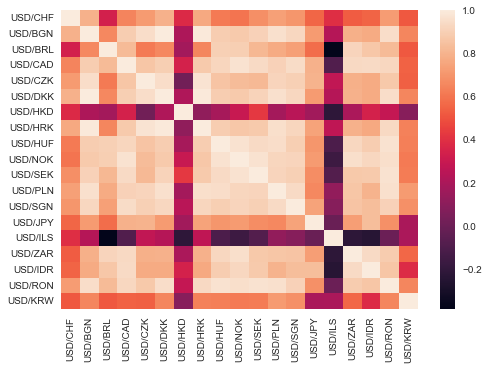

In [11]:
sns.heatmap(df.corr())
plt.savefig('charts/Heatmap.png')

In [12]:
df.head(3)

,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,USD/SEK,USD/PLN,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW
Date,,,,,,,,,,,,,,,,,,,
2021-05-14,0.9013,1.61035,5.27315,1.2104,20.954,6.12265,7.76775,6.18815,292.33,8.2289,8.3356,3.73205,1.33255,109.355,3.27465,14.1183,14197.5,4.05495,1126.490
2021-05-14,0.9013,1.61035,5.27315,1.2104,20.954,6.12265,7.76775,6.18815,292.33,8.2289,8.3356,3.73205,1.33255,109.355,3.27465,14.1183,14197.5,4.05495,1126.490
2021-05-13,0.9061,1.61930,5.31000,1.2162,21.106,6.15580,7.76805,6.23155,295.47,8.3557,8.4011,3.74800,1.33345,109.465,3.28820,14.1150,14197.5,4.07945,1126.905


In [13]:
df.tail(3)

,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,USD/SEK,USD/PLN,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW
Date,,,,,,,,,,,,,,,,,,,
2011-05-19,0.88065,1.36665,1.6165,0.96760,17.062,5.21135,7.7740,5.18460,186.810,5.5005,6.25650,2.7391,1.2373,81.610,3.494,6.87500,8552.5,2.87285,1086.5
2011-05-18,0.88185,1.37270,1.6093,0.97050,17.184,5.23410,7.7750,5.20325,188.515,5.5413,6.29415,2.7486,1.2404,81.775,3.519,6.90700,8559.5,2.89565,1088.5
2011-05-17,0.88030,1.37390,1.6159,0.97225,17.174,5.23785,7.7744,5.19650,188.085,5.5679,6.32615,2.7570,1.2456,81.425,3.530,6.96135,8572.5,2.88775,1088.5


In [14]:
save_to_sql('df', df)

2021-12-13 16:01:41,931 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df")
2021-12-13 16:01:41,932 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:41,933 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df")
2021-12-13 16:01:41,934 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:41,938 INFO sqlalchemy.engine.Engine 
CREATE TABLE df (
	"Date" DATETIME, 
	"USD/CHF" FLOAT, 
	"USD/BGN" FLOAT, 
	"USD/BRL" FLOAT, 
	"USD/CAD" FLOAT, 
	"USD/CZK" FLOAT, 
	"USD/DKK" FLOAT, 
	"USD/HKD" FLOAT, 
	"USD/HRK" FLOAT, 
	"USD/HUF" FLOAT, 
	"USD/NOK" FLOAT, 
	"USD/SEK" FLOAT, 
	"USD/PLN" FLOAT, 
	"USD/SGN" FLOAT, 
	"USD/JPY" FLOAT, 
	"USD/ILS" FLOAT, 
	"USD/ZAR" FLOAT, 
	"USD/IDR" FLOAT, 
	"USD/RON" FLOAT, 
	"USD/KRW" FLOAT
)


2021-12-13 16:01:41,939 INFO sqlalchemy.engine.Engine [no key 0.00118s] ()
2021-12-13 16:01:41,941 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:41,942 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_Date" ON df ("Date")
2021-12-13 16:

<h1 style="text-align:center;">Exploratory Data Analysis:</h1>

<h2 style="text-align:center;">Normality Test</h2>

A normality test is used to assess if sample data was taken from a population with a normally distributed distribution (within some tolerance). A normally distributed sample population is needed for a number of statistical tests, including the Student's t-test and one-way and two-way ANOVA. The results of the experiments would be inaccurate if the assumption of normality is not true.

Histogram plots can be used to understand the distribution visually. To see the distribution of the variables, a histogram plot is given below.

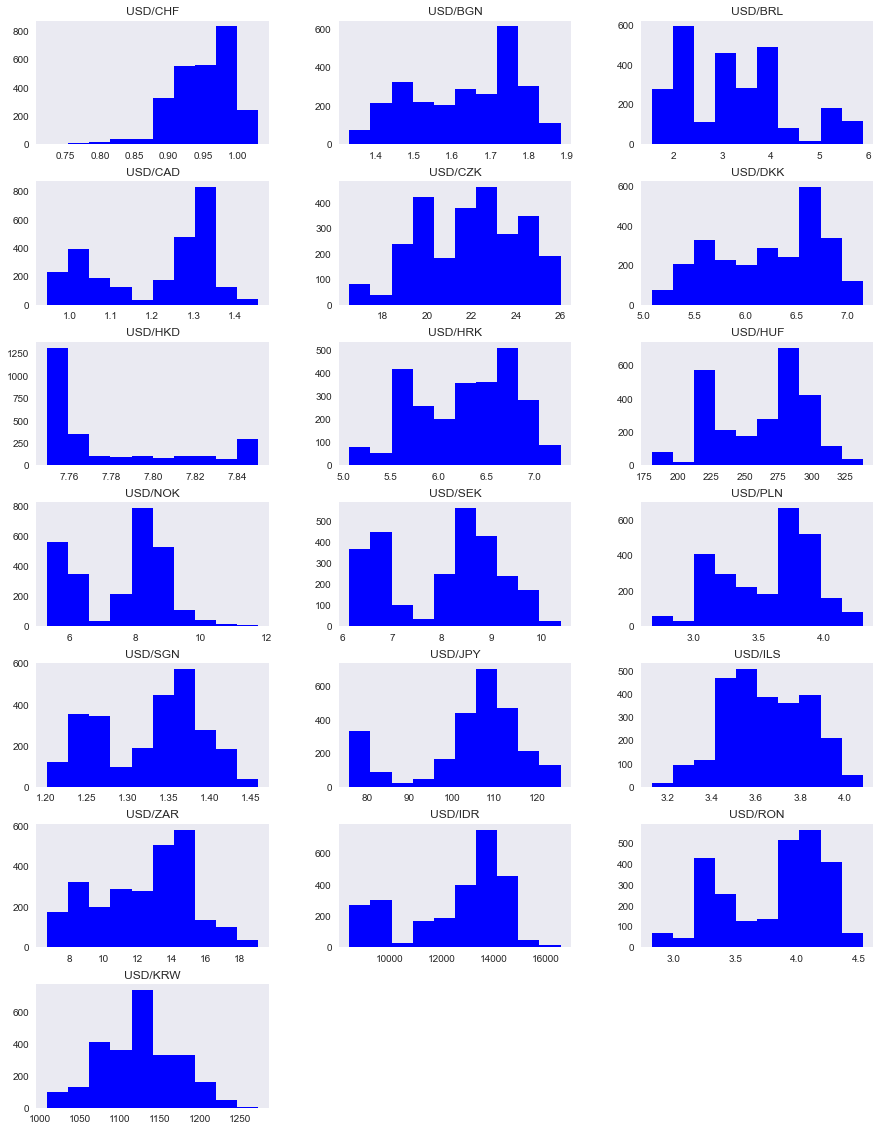

In [15]:
df.hist(layout=(7,3), color='blue', figsize=(15,20), grid=False)
plt.savefig('charts/Distribution.png')

<h3 style="text-align:center;">Jarque-Bera test: </h3>

This tests whether the sample has the skewness and kurtosis matching with a normal distribution, i.e., skewness=0 and kurtosis =3. 

H0 = The sample comes from a normal distribution.
H1 = The sample is not coming from normal distribution.

In [16]:
jb_result={}

for col in df[df.columns[:-3]]:
    jb_result[col] = jarque_bera(df[col])
    
jb_result

df_jb_result = pd.DataFrame()

for k,v in jb_result.items():
    df_jb_result = df_jb_result.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1]},
            index=[k]))
    
df_jb_result.index.name = 'Currency'
df_jb_result.sort_values(by=['t-test'], inplace=True)

df_jb_result


,t-test,p-value
Currency,,
USD/ILS,60.549772,7.105427e-14
USD/ZAR,92.291973,0.000000e+00
USD/CZK,92.656017,0.000000e+00
USD/BRL,137.179643,0.000000e+00
USD/HRK,141.040454,0.000000e+00
USD/HUF,145.018614,0.000000e+00
USD/PLN,152.861230,0.000000e+00
USD/SGN,160.787514,0.000000e+00
USD/NOK,174.763009,0.000000e+00


In [17]:
save_to_sql("df_jb_result", df_jb_result)

2021-12-13 16:01:44,440 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_jb_result")
2021-12-13 16:01:44,441 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:44,443 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_jb_result")
2021-12-13 16:01:44,444 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:44,445 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_jb_result (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT
)


2021-12-13 16:01:44,446 INFO sqlalchemy.engine.Engine [no key 0.00091s] ()
2021-12-13 16:01:44,449 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:44,450 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_jb_result_Currency" ON df_jb_result ("Currency")
2021-12-13 16:01:44,450 INFO sqlalchemy.engine.Engine [no key 0.00078s] ()
2021-12-13 16:01:44,453 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:44,455 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-12-13 16:01:44,457 INFO sqlalchemy.engine.Engine INSERT INTO df_jb_r

 <h1 style="text-align:center;">Check for Seasonality</h1>

Seasonal variation refers to a recurring pattern within each year, though the term is more broadly applied to recurring patterns within any fixed time.

In [18]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday

df.head()

,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,...,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW,Year,Month,Weekday
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-14,0.90130,1.61035,5.27315,1.21040,20.954,6.12265,7.76775,6.18815,292.33,8.2289,...,1.33255,109.355,3.27465,14.1183,14197.5,4.05495,1126.490,2021,5,4
2021-05-14,0.90130,1.61035,5.27315,1.21040,20.954,6.12265,7.76775,6.18815,292.33,8.2289,...,1.33255,109.355,3.27465,14.1183,14197.5,4.05495,1126.490,2021,5,4
2021-05-13,0.90610,1.61930,5.31000,1.21620,21.106,6.15580,7.76805,6.23155,295.47,8.3557,...,1.33345,109.465,3.28820,14.1150,14197.5,4.07945,1126.905,2021,5,3
2021-05-12,0.90930,1.62030,5.30695,1.21330,21.214,6.15880,7.76595,6.23625,296.17,8.3393,...,1.33375,109.665,3.28850,14.1213,14197.5,4.08255,1132.905,2021,5,2
2021-05-11,0.90375,1.60995,5.22165,1.21025,21.003,6.12050,7.76845,6.19505,295.20,8.2618,...,1.32555,108.615,3.29030,14.0018,14197.5,4.05605,1119.755,2021,5,1


Month-wise Box Plot

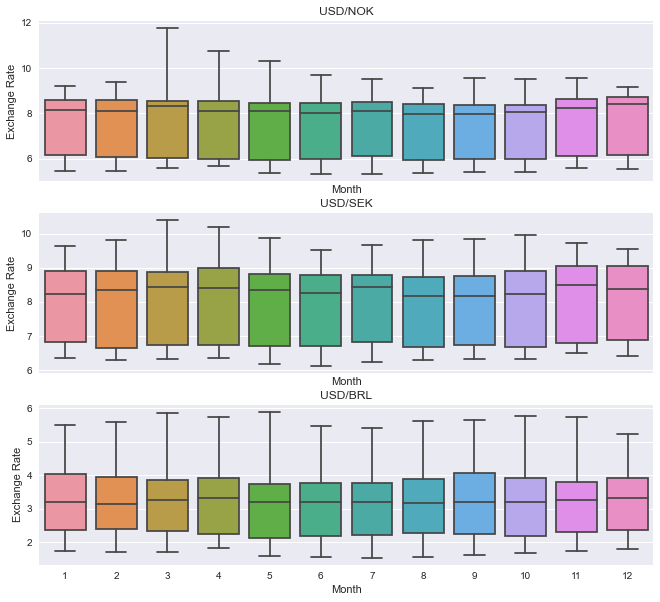

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['USD/NOK','USD/SEK','USD/BRL'], axes):
    sns.boxplot(data=df, x='Month', y=name, ax=ax)
    ax.set_ylabel('Exchange Rate')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

plt.savefig('charts/BoxPlot.png')

<h2 style="text-align:center;"> Check for Trend</h2>

Trend analysis is the process of examining data for patterns in its graphical representation.

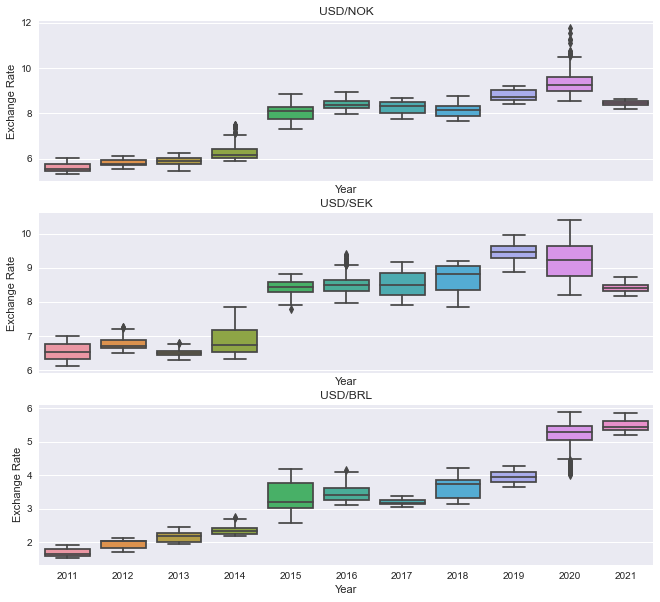

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['USD/NOK','USD/SEK','USD/BRL'], axes):
    sns.boxplot(data=df, x='Year', y=name, ax=ax)
    ax.set_ylabel('Exchange Rate')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

plt.savefig('charts/Trend.png')

<h1 style="text-align:center;">Test for Stationarity</h1>

<p style="text-align:justify;">If a time series has no pattern or seasonal impact, it is said to be stationary. Summary statistics calculated on time series, such as the mean or variance of the findings, are consistent over time. <br><br> First, we wanted to find out what currency pairs are more or less likely for stationarity. We applied the Augmented Dickey-Fuller test (ad-fuller test) on the raw data: <br><br> t-statistics: More negative means more likely to be stationary 
Table sorted from lowest to highest t-statistic:</p>

In [21]:

currency_result={}

for col in df[df.columns[:-3]]:
    currency_result[col] = adfuller((df['USD/'+ col.split("/")[-1]]), maxlag=None, autolag='BIC', regression='c')
    
currency_result

df_currency_result = pd.DataFrame()

for k,v in currency_result.items():
    df_currency_result = df_currency_result.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_currency_result.index.name = 'Currency'
df_currency_result.sort_values(by=['t-test'], inplace=True)

df_currency_result

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422378,0.010219,-3.432859,-2.862648,-2.567360
USD/KRW,-3.028018,0.032359,-3.432859,-2.862648,-2.567360
USD/ILS,-2.554761,0.102712,-3.432859,-2.862648,-2.567360
USD/HKD,-2.005806,0.284033,-3.432859,-2.862648,-2.567360
USD/SGN,-1.591184,0.488021,-3.432859,-2.862648,-2.567360
USD/BRL,-1.210101,0.669236,-3.432860,-2.862649,-2.567360
USD/PLN,-1.163130,0.689252,-3.432859,-2.862648,-2.567360
USD/HRK,-1.012391,0.748718,-3.432859,-2.862648,-2.567360
USD/BGN,-1.001689,0.752648,-3.432859,-2.862648,-2.567360


In [22]:
save_to_sql("df_currency_result", df_currency_result)

2021-12-13 16:01:47,083 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_currency_result")
2021-12-13 16:01:47,084 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:47,085 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_currency_result")
2021-12-13 16:01:47,086 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:47,088 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_currency_result (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:47,088 INFO sqlalchemy.engine.Engine [no key 0.00087s] ()
2021-12-13 16:01:47,091 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:47,092 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_currency_result_Currency" ON df_currency_result ("Currency")
2021-12-13 16:01:47,092 INFO sqlalchemy.engine.Engine [no key 0.00061s] ()
2021-12-13 16:01:47,095 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:47,098 INFO sqlalchemy.engine.Engine BEGIN (implicit)


Top 3: according to t-statistic most stationary Spot Rates 

Graphical representation: 

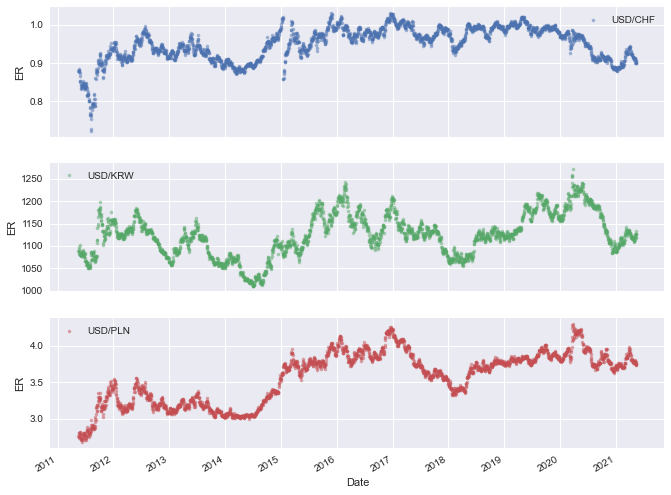

In [23]:
cols_plot = ['USD/CHF', 'USD/KRW', 'USD/PLN']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('ER')
plt.savefig('charts/Stationarity1.png')

Top 3: according to t-statistic most non stationary Spot Rates

Graphicaly representation: 

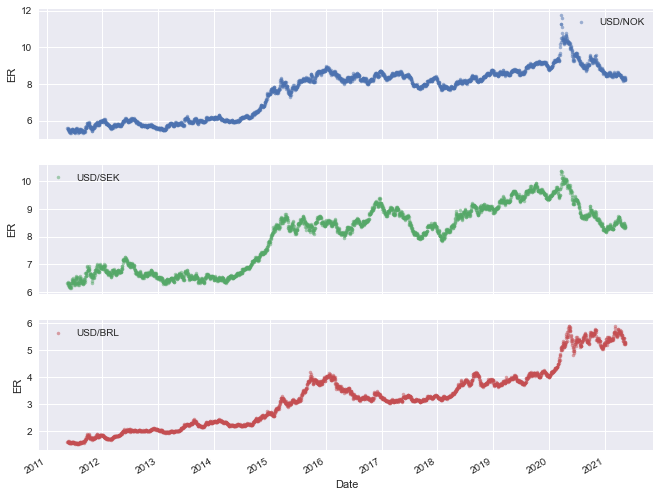

In [24]:
cols_plot = ['USD/NOK','USD/SEK','USD/BRL']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('ER')
plt.savefig('charts/Stationarity2.png')

<b>Lag</b> - fixed amount of time that passes between two sets of observations in a time series that are plotted (lagged) against a second, later set of results. The kth lag is the amount of time that passed between “k” time points and time i.

AD-Fuller Test on 1 lag:

In [25]:

currency_result_1_lag={}

for col in df[df.columns[:-3]]:
    currency_result_1_lag[col] = adfuller((df['USD/'+ col.split("/")[-1]]), maxlag=1, autolag='BIC', regression='c')
    
currency_result_1_lag

df_currency_result_1_lag = pd.DataFrame()

for k,v in currency_result_1_lag.items():
    df_currency_result_1_lag = df_currency_result_1_lag.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_currency_result_1_lag.index.name = 'Currency'
df_currency_result_1_lag.sort_values(by=['t-test'], inplace=True)

df_currency_result_1_lag

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422378,0.010219,-3.432859,-2.862648,-2.56736
USD/KRW,-3.028018,0.032359,-3.432859,-2.862648,-2.56736
USD/ILS,-2.554761,0.102712,-3.432859,-2.862648,-2.56736
USD/HKD,-2.005806,0.284033,-3.432859,-2.862648,-2.56736
USD/SGN,-1.591184,0.488021,-3.432859,-2.862648,-2.56736
USD/BRL,-1.210101,0.669236,-3.432860,-2.862649,-2.56736
USD/PLN,-1.163130,0.689252,-3.432859,-2.862648,-2.56736
USD/HRK,-1.012391,0.748718,-3.432859,-2.862648,-2.56736
USD/BGN,-1.001689,0.752648,-3.432859,-2.862648,-2.56736


In [26]:
save_to_sql("df_currency_result_1_lag", df_currency_result_1_lag)

2021-12-13 16:01:48,775 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_currency_result_1_lag")
2021-12-13 16:01:48,776 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:48,777 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_currency_result_1_lag")
2021-12-13 16:01:48,778 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:48,779 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_currency_result_1_lag (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:48,780 INFO sqlalchemy.engine.Engine [no key 0.00061s] ()
2021-12-13 16:01:48,782 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:48,783 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_currency_result_1_lag_Currency" ON df_currency_result_1_lag ("Currency")
2021-12-13 16:01:48,784 INFO sqlalchemy.engine.Engine [no key 0.00057s] ()
2021-12-13 16:01:48,785 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:48,788 INFO sqlalchemy.e

AD-Fuller Test on 2 lags:

In [27]:
currency_result_2_lag={}

for col in df[df.columns[:-3]]:
    currency_result_2_lag[col] = adfuller((df['USD/'+ col.split("/")[-1]]), maxlag=2, autolag='BIC', regression='c')
    
currency_result_2_lag

df_currency_result_2_lag = pd.DataFrame()

for k,v in currency_result_2_lag.items():
    df_currency_result_2_lag = df_currency_result_2_lag.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_currency_result_2_lag.index.name = 'Currency'
df_currency_result_2_lag.sort_values(by=['t-test'], inplace=True)

df_currency_result_2_lag

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422378,0.010219,-3.432859,-2.862648,-2.567360
USD/KRW,-3.028018,0.032359,-3.432859,-2.862648,-2.567360
USD/ILS,-2.554761,0.102712,-3.432859,-2.862648,-2.567360
USD/HKD,-2.005806,0.284033,-3.432859,-2.862648,-2.567360
USD/SGN,-1.591184,0.488021,-3.432859,-2.862648,-2.567360
USD/BRL,-1.210101,0.669236,-3.432860,-2.862649,-2.567360
USD/PLN,-1.163130,0.689252,-3.432859,-2.862648,-2.567360
USD/HRK,-1.012391,0.748718,-3.432859,-2.862648,-2.567360
USD/BGN,-1.001689,0.752648,-3.432859,-2.862648,-2.567360


In [28]:
save_to_sql("df_currency_result_2_lag", df_currency_result_2_lag)

2021-12-13 16:01:48,902 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_currency_result_2_lag")
2021-12-13 16:01:48,903 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:48,904 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_currency_result_2_lag")
2021-12-13 16:01:48,905 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:48,907 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_currency_result_2_lag (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:48,908 INFO sqlalchemy.engine.Engine [no key 0.00079s] ()
2021-12-13 16:01:48,910 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:48,911 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_currency_result_2_lag_Currency" ON df_currency_result_2_lag ("Currency")
2021-12-13 16:01:48,912 INFO sqlalchemy.engine.Engine [no key 0.00077s] ()
2021-12-13 16:01:48,914 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:48,917 INFO sqlalchemy.e

Differencing 
Computing the differences between consecutive observations is known as differencing.
Pandas diff will subtract 1 cell value from another cell value within the same index.

In [29]:
data_diff_1 = df.diff(periods=1)     
df.dropna()
data_diff_1 = df.iloc[1:]
data_diff_1.head(5) 


,USD/CHF,USD/BGN,USD/BRL,USD/CAD,USD/CZK,USD/DKK,USD/HKD,USD/HRK,USD/HUF,USD/NOK,...,USD/SGN,USD/JPY,USD/ILS,USD/ZAR,USD/IDR,USD/RON,USD/KRW,Year,Month,Weekday
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-14,0.90130,1.61035,5.27315,1.21040,20.954,6.12265,7.76775,6.18815,292.33,8.2289,...,1.33255,109.355,3.27465,14.1183,14197.5,4.05495,1126.490,2021,5,4
2021-05-13,0.90610,1.61930,5.31000,1.21620,21.106,6.15580,7.76805,6.23155,295.47,8.3557,...,1.33345,109.465,3.28820,14.1150,14197.5,4.07945,1126.905,2021,5,3
2021-05-12,0.90930,1.62030,5.30695,1.21330,21.214,6.15880,7.76595,6.23625,296.17,8.3393,...,1.33375,109.665,3.28850,14.1213,14197.5,4.08255,1132.905,2021,5,2
2021-05-11,0.90375,1.60995,5.22165,1.21025,21.003,6.12050,7.76845,6.19505,295.20,8.2618,...,1.32555,108.615,3.29030,14.0018,14197.5,4.05605,1119.755,2021,5,1
2021-05-10,0.90130,1.61240,5.22825,1.20990,21.080,6.13075,7.76545,6.21695,294.99,8.2716,...,1.32575,108.795,3.26050,14.0465,14197.5,4.06200,1116.855,2021,5,0


After testing the raw data for stationarity we now test the first difference for stationarity with the AD-Fuller Test: 

In [30]:
diff1_currency_result={}

for col in data_diff_1[df.columns[:-3]]:
    diff1_currency_result[col] = adfuller((data_diff_1['USD/'+ col.split("/")[-1]]), maxlag=None, autolag='BIC', regression='c')
    
diff1_currency_result

df_diff1_currency_result = pd.DataFrame()

for k,v in diff1_currency_result.items():
    df_diff1_currency_result = df_diff1_currency_result.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_diff1_currency_result.index.name = 'Currency'
df_diff1_currency_result.sort_values(by=['t-test'], inplace=True)

df_diff1_currency_result

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422512,0.010215,-3.432860,-2.862649,-2.567360
USD/KRW,-3.027438,0.032410,-3.432860,-2.862649,-2.567360
USD/ILS,-2.556459,0.102334,-3.432860,-2.862649,-2.567360
USD/HKD,-2.005464,0.284183,-3.432860,-2.862649,-2.567360
USD/SGN,-1.590891,0.488167,-3.432860,-2.862649,-2.567360
USD/BRL,-1.248076,0.652580,-3.432861,-2.862649,-2.567361
USD/PLN,-1.163082,0.689272,-3.432860,-2.862649,-2.567360
USD/HRK,-1.012163,0.748802,-3.432860,-2.862649,-2.567360
USD/BGN,-1.001465,0.752729,-3.432860,-2.862649,-2.567360


In [31]:
save_to_sql("df_diff1_currency_result", df_diff1_currency_result)

2021-12-13 16:01:49,996 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_diff1_currency_result")
2021-12-13 16:01:49,997 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:49,999 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_diff1_currency_result")
2021-12-13 16:01:50,000 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:50,001 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_diff1_currency_result (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:50,002 INFO sqlalchemy.engine.Engine [no key 0.00078s] ()
2021-12-13 16:01:50,004 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:50,005 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_diff1_currency_result_Currency" ON df_diff1_currency_result ("Currency")
2021-12-13 16:01:50,006 INFO sqlalchemy.engine.Engine [no key 0.00067s] ()
2021-12-13 16:01:50,008 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:50,011 INFO sqlalchemy.e

Testing first difference for stationarity with 1 lag:

In [32]:
diff1_currency_result_1_lag={}

for col in data_diff_1[df.columns[:-3]]:
    diff1_currency_result_1_lag[col] = adfuller((data_diff_1['USD/'+ col.split("/")[-1]]), maxlag=1, autolag='BIC', regression='c')
    
diff1_currency_result_1_lag

df_diff1_currency_result_1_lag = pd.DataFrame()

for k,v in diff1_currency_result_1_lag.items():
    df_diff1_currency_result_1_lag = df_diff1_currency_result_1_lag.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_diff1_currency_result_1_lag.index.name = 'Currency'
df_diff1_currency_result_1_lag.sort_values(by=['t-test'], inplace=True)

df_diff1_currency_result_1_lag

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422512,0.010215,-3.432860,-2.862649,-2.567360
USD/KRW,-3.027438,0.032410,-3.432860,-2.862649,-2.567360
USD/ILS,-2.556459,0.102334,-3.432860,-2.862649,-2.567360
USD/HKD,-2.005464,0.284183,-3.432860,-2.862649,-2.567360
USD/SGN,-1.590891,0.488167,-3.432860,-2.862649,-2.567360
USD/BRL,-1.248076,0.652580,-3.432861,-2.862649,-2.567361
USD/PLN,-1.163082,0.689272,-3.432860,-2.862649,-2.567360
USD/HRK,-1.012163,0.748802,-3.432860,-2.862649,-2.567360
USD/BGN,-1.001465,0.752729,-3.432860,-2.862649,-2.567360


In [33]:
save_to_sql("df_diff1_currency_result_1_lag", df_diff1_currency_result_1_lag)

2021-12-13 16:01:50,112 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_diff1_currency_result_1_lag")
2021-12-13 16:01:50,113 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:50,115 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_diff1_currency_result_1_lag")
2021-12-13 16:01:50,115 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:50,117 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_diff1_currency_result_1_lag (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:50,118 INFO sqlalchemy.engine.Engine [no key 0.00066s] ()
2021-12-13 16:01:50,120 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:50,121 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_diff1_currency_result_1_lag_Currency" ON df_diff1_currency_result_1_lag ("Currency")
2021-12-13 16:01:50,121 INFO sqlalchemy.engine.Engine [no key 0.00064s] ()
2021-12-13 16:01:50,123 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 

Testing first difference for stationarity with 2 lag:

In [34]:
diff1_currency_result_2_lag={}

for col in data_diff_1[df.columns[:-3]]:
    diff1_currency_result_2_lag[col] = adfuller((data_diff_1['USD/'+ col.split("/")[-1]]), maxlag=2, autolag='BIC', regression='c')
    
diff1_currency_result_2_lag

df_diff1_currency_result_2_lag = pd.DataFrame()

for k,v in diff1_currency_result_2_lag.items():
    df_diff1_currency_result_2_lag = df_diff1_currency_result_2_lag.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
    
df_diff1_currency_result_2_lag.index.name = 'Currency'
df_diff1_currency_result_2_lag.sort_values(by=['t-test'], inplace=True)

df_diff1_currency_result_2_lag

,t-test,p-value,1%,5%,10%
Currency,,,,,
USD/CHF,-3.422512,0.010215,-3.432860,-2.862649,-2.567360
USD/KRW,-3.027438,0.032410,-3.432860,-2.862649,-2.567360
USD/ILS,-2.556459,0.102334,-3.432860,-2.862649,-2.567360
USD/HKD,-2.005464,0.284183,-3.432860,-2.862649,-2.567360
USD/SGN,-1.590891,0.488167,-3.432860,-2.862649,-2.567360
USD/BRL,-1.248076,0.652580,-3.432861,-2.862649,-2.567361
USD/PLN,-1.163082,0.689272,-3.432860,-2.862649,-2.567360
USD/HRK,-1.012163,0.748802,-3.432860,-2.862649,-2.567360
USD/BGN,-1.001465,0.752729,-3.432860,-2.862649,-2.567360


In [35]:
save_to_sql("df_diff1_currency_result_2_lag", df_diff1_currency_result_2_lag)

2021-12-13 16:01:50,240 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_diff1_currency_result_2_lag")
2021-12-13 16:01:50,241 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:50,242 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_diff1_currency_result_2_lag")
2021-12-13 16:01:50,243 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:50,245 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_diff1_currency_result_2_lag (
	"Currency" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:50,246 INFO sqlalchemy.engine.Engine [no key 0.00078s] ()
2021-12-13 16:01:50,248 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:50,249 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_diff1_currency_result_2_lag_Currency" ON df_diff1_currency_result_2_lag ("Currency")
2021-12-13 16:01:50,249 INFO sqlalchemy.engine.Engine [no key 0.00067s] ()
2021-12-13 16:01:50,252 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 

 <h1 style="text-align:center;">Check for Cointegration</h1>

Cointegration focuses on whether the spread between two series is constant over time.

Null hypothesis: The spread between two series is non-stationary 
If you can reject the null hypothesis, then this suggests that the spread is stationary over time

Top 2: according to t-statistic (obtained through Ad-fuller) on raw data most stationary Spot Rates and their spread:

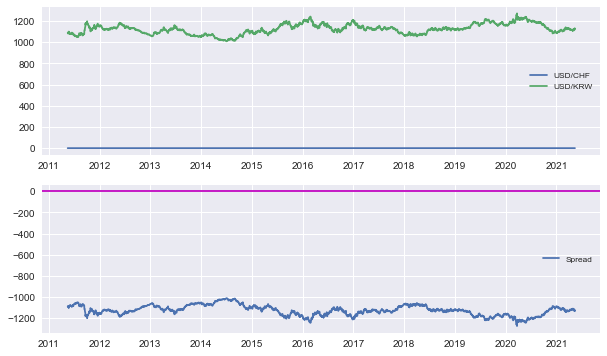

In [36]:
register_matplotlib_converters()

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(df['USD/CHF'], label='USD/CHF')
plt.plot(df['USD/KRW'], label='USD/KRW')
plt.legend(loc='best', fontsize='small')

plt.subplot(2,1,2)
plt.plot(df['USD/CHF']-df['USD/KRW'], label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='-', color='m')
plt.savefig('charts/MostStationarySpotRates.png')
plt.show()

In [37]:
result_spread1 = adfuller(df['USD/CHF']-df['USD/KRW'])
print("The p-value for the ADF test on the spread is ", result_spread1 [1])

The p-value for the ADF test on the spread is  0.03867968047598692


<p style="text-align:justify;">Again, we have stationarity for both series and the difference between them, namely the spread. Hence, the two series are cointegrated with thep-value not exceeding the 0.05 threshold. The spread is stationary. </p>

Top 2: according to t-statistic non-stationary 

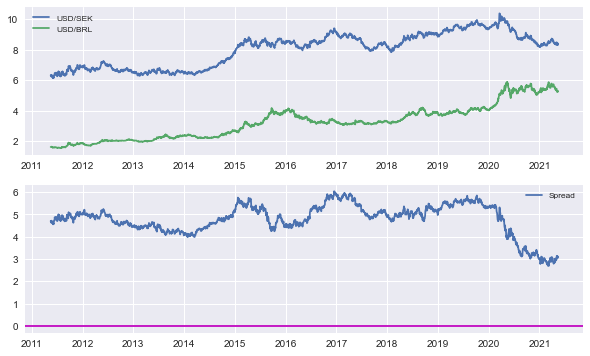

In [38]:
register_matplotlib_converters()

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(df['USD/SEK'], label='USD/SEK')
plt.plot(df['USD/BRL'], label='USD/BRL')
plt.legend(loc='best', fontsize='small')
plt.subplot(2,1,2)
plt.plot(df['USD/SEK']-df['USD/BRL'], label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='-', color='m')
plt.savefig('charts/LeastStationarySpotRates.png')
plt.show()



In [39]:
result_spread2 = adfuller(df['USD/SEK']-df['USD/BRL'])
print("The p-value for the ADF test on the spread is ", result_spread2 [1])

The p-value for the ADF test on the spread is  0.06531344878208283


<p style="text-align:justify;">Again, we have non stationarity for both series and the difference between them, namely the spread. Hence, the two series are not cointegrated with the p-value far exceeding the 0.05 threshold. The spread is not stationary. </p>

Following the test the spread for stationarity between <b>all currencies</b>:

In [40]:
# Loop for 0 Lag.
result_0_lag={}
iterators_list = ["CHF", "BGN", "BRL", "CAD", "CZK", "DKK", "HKD", "HRK", "HUF", "NOK", "SEK",\
                  "PLN", "SGN", "JPY", "ILS", "ZAR", "IDR", "RON", "KRW"]

for i in range(len(iterators_list)):
    for j in range(i + 1, len(iterators_list)):
            result_0_lag[f'{iterators_list[j]}/' + iterators_list[i]] = \
            adfuller(df[f'USD/{iterators_list[j]}'] - df['USD/'+ iterators_list[i]], maxlag=0)
            
df_result_spread = pd.DataFrame()

for k,v in result_0_lag.items():
    df_result_spread = df_result_spread.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
df_result_spread.index.name = 'Spreads'

df_result_spread.sort_values(by=['t-test'], inplace=True)

df_result_spread


,t-test,p-value,1%,5%,10%
Spreads,,,,,
KRW/HUF,-3.613114,0.005515,-3.432859,-2.862648,-2.56736
HKD/CHF,-3.609984,0.005573,-3.432859,-2.862648,-2.56736
SGN/CHF,-3.477063,0.008596,-3.432859,-2.862648,-2.56736
HRK/DKK,-3.440009,0.009668,-3.432859,-2.862648,-2.56736
CAD/BGN,-3.214392,0.019167,-3.432859,-2.862648,-2.56736
...,...,...,...,...,...
IDR/CAD,0.518019,0.985411,-3.432859,-2.862648,-2.56736
IDR/CHF,0.518087,0.985413,-3.432859,-2.862648,-2.56736
IDR/SGN,0.518122,0.985414,-3.432859,-2.862648,-2.56736


In [41]:
save_to_sql("df_result_spread", df_result_spread)

2021-12-13 16:01:51,761 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_result_spread")
2021-12-13 16:01:51,762 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:51,763 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_result_spread")
2021-12-13 16:01:51,764 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:51,765 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_result_spread (
	"Spreads" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:51,766 INFO sqlalchemy.engine.Engine [no key 0.00071s] ()
2021-12-13 16:01:51,768 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:51,769 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_result_spread_Spreads" ON df_result_spread ("Spreads")
2021-12-13 16:01:51,769 INFO sqlalchemy.engine.Engine [no key 0.00052s] ()
2021-12-13 16:01:51,771 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:51,774 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-12-13 16

Test the spread for stationarity between all currencies: 
Loop for <b>1 Lag</b>:

In [42]:
result_1_lag={}
iterators_list = ["CHF", "BGN", "BRL", "CAD", "CZK", "DKK", "HKD", "HRK", "HUF", "NOK", "SEK",\
                  "PLN", "SGN", "JPY", "ILS", "ZAR", "IDR", "RON", "KRW"]

for i in range(len(iterators_list)):
    for j in range(i + 1, len(iterators_list)):
            result_1_lag[f'{iterators_list[j]}/' + iterators_list[i]] = \
            adfuller(df[f'USD/{iterators_list[j]}'] - df['USD/'+ iterators_list[i]], maxlag=1)

df_result_spread_1 = pd.DataFrame()

for k,v in result_1_lag.items():
    df_result_spread_1 = df_result_spread_1.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
df_result_spread_1.index.name = 'Spreads'

df_result_spread_1.sort_values(by=['t-test'], inplace=True)

df_result_spread_1

,t-test,p-value,1%,5%,10%
Spreads,,,,,
HKD/CHF,-3.609984,0.005573,-3.432859,-2.862648,-2.56736
KRW/HUF,-3.314649,0.014236,-3.432860,-2.862649,-2.56736
SGN/CHF,-3.313551,0.014283,-3.432860,-2.862649,-2.56736
CAD/BGN,-3.088694,0.027401,-3.432860,-2.862649,-2.56736
RON/PLN,-2.959387,0.038865,-3.432860,-2.862649,-2.56736
...,...,...,...,...,...
IDR/HKD,0.286074,0.976696,-3.432860,-2.862649,-2.56736
IDR/SGN,0.286084,0.976697,-3.432860,-2.862649,-2.56736
IDR/NOK,0.286155,0.976700,-3.432860,-2.862649,-2.56736


In [43]:
save_to_sql("df_result_spread_1", df_result_spread_1)

2021-12-13 16:01:52,331 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_result_spread_1")
2021-12-13 16:01:52,332 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:52,334 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_result_spread_1")
2021-12-13 16:01:52,334 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:52,336 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_result_spread_1 (
	"Spreads" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:52,336 INFO sqlalchemy.engine.Engine [no key 0.00063s] ()
2021-12-13 16:01:52,338 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:52,339 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_result_spread_1_Spreads" ON df_result_spread_1 ("Spreads")
2021-12-13 16:01:52,339 INFO sqlalchemy.engine.Engine [no key 0.00049s] ()
2021-12-13 16:01:52,341 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:52,345 INFO sqlalchemy.engine.Engine BEGIN (implicit)
202

Test the spread for stationarity between all currencies:
 Loop for <b>2 Lags</b>:

In [44]:
result_2_lag={}
iterators_list = ["CHF", "BGN", "BRL", "CAD", "CZK", "DKK", "HKD", "HRK", "HUF", "NOK", "SEK",\
                  "PLN", "SGN", "JPY", "ILS", "ZAR", "IDR", "RON", "KRW"]

for i in range(len(iterators_list)):
    for j in range(i + 1, len(iterators_list)):
            result_2_lag[f'{iterators_list[j]}/' + iterators_list[i]] = \
            adfuller(df[f'USD/{iterators_list[j]}'] - df['USD/'+ iterators_list[i]], maxlag=2)

df_result_spread_2 = pd.DataFrame()

for k,v in result_2_lag.items():
    df_result_spread_2 = df_result_spread_2.append(pd.DataFrame(
            data={'t-test':v[0], 'p-value':v[1], '1%':v[4]['1%'], '5%':v[4]['5%'], '10%':v[4]['10%']},
            index=[k]))
df_result_spread_2.index.name = 'Spreads'

df_result_spread_2.sort_values(by=['t-test'], inplace=True)

df_result_spread_2

,t-test,p-value,1%,5%,10%
Spreads,,,,,
HKD/CHF,-3.609984,0.005573,-3.432859,-2.862648,-2.567360
KRW/HUF,-3.422945,0.010201,-3.432861,-2.862649,-2.567361
SGN/CHF,-3.193250,0.020379,-3.432861,-2.862649,-2.567361
CAD/BGN,-3.088694,0.027401,-3.432860,-2.862649,-2.567360
KRW/ZAR,-3.032871,0.031937,-3.432861,-2.862649,-2.567361
...,...,...,...,...,...
IDR/CHF,0.069662,0.963928,-3.432861,-2.862649,-2.567361
IDR/HKD,0.069674,0.963929,-3.432861,-2.862649,-2.567361
IDR/SGN,0.069695,0.963930,-3.432861,-2.862649,-2.567361


In [45]:
save_to_sql("df_result_spread_2", df_result_spread_2)

2021-12-13 16:01:52,982 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("df_result_spread_2")
2021-12-13 16:01:52,983 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:52,985 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("df_result_spread_2")
2021-12-13 16:01:52,986 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-12-13 16:01:52,988 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_result_spread_2 (
	"Spreads" TEXT, 
	"t-test" FLOAT, 
	"p-value" FLOAT, 
	"1%" FLOAT, 
	"5%" FLOAT, 
	"10%" FLOAT
)


2021-12-13 16:01:52,989 INFO sqlalchemy.engine.Engine [no key 0.00090s] ()
2021-12-13 16:01:52,991 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:52,992 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_df_result_spread_2_Spreads" ON df_result_spread_2 ("Spreads")
2021-12-13 16:01:52,992 INFO sqlalchemy.engine.Engine [no key 0.00064s] ()
2021-12-13 16:01:52,995 INFO sqlalchemy.engine.Engine COMMIT
2021-12-13 16:01:52,997 INFO sqlalchemy.engine.Engine BEGIN (implicit)
202